<h2>Importing Libraries</h2>

As usual, we need numpy for numerical calculations, pandas for working with dataframes in the latter part of the project and matplotlib.pyplot to visualise the EEG recordings as a time-series on a plot. 

However, a library called ```mne``` will be used to read in the raw EDF file into the workspace (for both the recording and the hypnogram/annotations). We import the libraries in the subsequent code cells.

In [2]:
# Importing the basic libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style for all matplotlib visualisations
sns.set()

In [3]:
# Importing the libraries for EDF file processing:
import mne

# The next are MNE functions that have been used in custom functions for convenience:
from edf_annot_extract import read_edf_annotations, set_the_annotations

<h2>Reading In The Raw EDF Files</h2>

We are now ready to import the raw EDF files into the workspace (that is, the PSG recording and the associated hypnogram). These files come from a repository of PSG recordings courtesy of <i>Physionet.org</i>. The link to the main webpage and the repository are shown in the link below. 

- <b>The Sleep-EDF Database [Expanded] - Webpage</b><br>
https://physionet.org/pn6/sleep-edfx/ <br>

- <b>Sleep-EDF Database Repository</b><br>
https://physionet.org/pn6/sleep-edfx/sleep-cassette/

We begin reading the files beginning with the following code cells. The file names will change constantly as more than one PSG recording will be read, viewed and processed for QPS parameter extraction.

In [4]:
# Assign the path name for the main 'sleep_data' folder and the filename for the raw PSG recording and the hypnogram
path_name = 'C:\\Users\\Jason Ha\\Documents\\University\\4th Year\\Thesis Project (Repo)\\Jupyter Notebooks\\sleep_data' + '\\'
raw_filename = 'SC4001E0-PSG.edf'
hypnogram_filename = 'SC4001EC-Hypnogram.edf'

# Read the raw PSG EDF folder using mne
raw = mne.io.read_raw_edf(path_name + raw_filename, preload=True)

Extracting EDF parameters from C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\sleep_data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-4-858982a625c9>:7: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = mne.io.read_raw_edf(path_name + raw_filename, preload=True)


In [5]:
# Print out the info associated with raw:
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, STI 014
    chs : list | 7 items (EEG: 6, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 50.0 Hz
    meas_date : tuple | 1989-04-24 16:13:00 GMT
    nchan : int | 7
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
 

The info print out shows a few pieces of important information, namely:

- <b>There are 7 channels:</b> EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG submental, Temp rectal, STI 014
- <b>There are 2 EEG Channels: </b> EEG Fpz-Cz, EEG Pz-Oz which are measured via bipolar electrode configuration. One of the pairs measures the prefrontal lobe and the 'central' lobe along the referential (central, z) line of the scalp. The other pair measures the parietal lobe and occipital lobe along the referential axis of the scalp.
- <b>Sampling Frequency ($f_s$):</b> 100.0 Hz

In [6]:
raw.info['ch_names']

['EEG Fpz-Cz',
 'EEG Pz-Oz',
 'EOG horizontal',
 'Resp oro-nasal',
 'EMG submental',
 'Temp rectal',
 'STI 014']

We now want to find events that have occured in the PSG recording. To do this, we need to first load the annotations from the filename assigned to ```hypnogram_filename```to the raw PSG data. To do this, we use a few functions from a custom file called ``` df_annot_extract``` which contains two functions:

- ```read_edf_annotations```: Reads annotations from a hypnogram EDF file
- ```set_the_annotation```: Which uses MNE to set the annotations on top of the raw PSG recording.

We use these functions in the following code cells:

In [7]:
# Obtain the annotations from the EDF hympnogram file.
annot = read_edf_annotations(path_name + hypnogram_filename)

# Set the annotations on top of the raw PSG EDF file. No need for a return from the function:
mne_annot = mne.Annotations(annot.onset, annot.duration, annot.description)

# Loading the annotations onto the raw PSG data
raw.set_annotations(mne_annot)

# We now obtain the events and event_id from the raw data after the annotations being loaded.
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage ?']


<ipython-input-7-9ca6e1e9e3b3>:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne_annot)


In [8]:
order = np.arange(raw.info['nchan'])
order

array([0, 1, 2, 3, 4, 5, 6])

In [9]:
# Using the events to extract epochs from the raw PSG recording
epochs = mne.Epochs(raw, events, event_id, tmin=0., tmax=15.,baseline=None)

154 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [10]:
epochs

<Epochs  |   154 events (good & bad), 0 - 15 sec, baseline off, ~18 kB, data not loaded,
 'Sleep stage 1': 24
 'Sleep stage 2': 40
 'Sleep stage 3': 48
 'Sleep stage 4': 23
 'Sleep stage ?': 1
 'Sleep stage R': 6
 'Sleep stage W': 12>

In [11]:
#%matplotlib inline
#epochs.plot()
#plt.show()

In [12]:
index, scaling_time, scalings = ['epoch', 'time'], 1e3, dict(grad=1e13)

df = epochs.to_data_frame(picks=None, scalings=scalings,
                          scaling_time=scaling_time, index=index)

Loading data for 154 events and 1501 original time points ...
1 bad epochs dropped
Converting time column to int64...


In [13]:
df.head()

signal          condition  EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  \
epoch time                                                         
0     0     Sleep stage W    5.016850  -2.467399       16.508669   
      10    Sleep stage W   -2.578755   1.467399       16.015873   
      20    Sleep stage W    1.359707  -4.098901        9.609524   
      30    Sleep stage W   -2.391209  -2.659341        1.724786   
      40    Sleep stage W   -5.204396  -0.739927        7.638339   

signal      Resp oro-nasal  EMG submental   Temp rectal  STI 014  
epoch time                                                        
0     0       -482000000.0          3.552  3.720645e+07    920.0  
      10      -477000000.0          3.552  3.720538e+07    920.0  
      20      -472000000.0          3.554  3.720538e+07    920.0  
      30      -467000000.0          3.556  3.720538e+07    920.0  
      40      -462000000.0          3.558  3.720430e+07    920.0

We have successfully converted the raw PSG recording into a dataframe where events are labelled with their associated ```condition``` per the annotations that we set earlier in the notebook. To make things easier for the latter part of the project, we would like to remove columns that are NOT associated with the EEG recordings. We drop these columns in the subsequent code cell.

In [14]:
df.columns

Index(['condition', 'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal',
       'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'STI 014'],
      dtype='object', name='signal')

In [15]:
columns_to_drop = ['EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'STI 014']
df = df.drop(columns_to_drop, axis=1)
df.head()

signal          condition  EEG Fpz-Cz  EEG Pz-Oz
epoch time                                      
0     0     Sleep stage W    5.016850  -2.467399
      10    Sleep stage W   -2.578755   1.467399
      20    Sleep stage W    1.359707  -4.098901
      30    Sleep stage W   -2.391209  -2.659341
      40    Sleep stage W   -5.204396  -0.739927

We have retained the portion of the dataframe associated only with the EEG recording. Because spindles begin to occur in Stage 2 (N2) NREM sleep, we want to retain a portion of the dataframe associated with the Stage 2 epochs. While spindles occur in subsequent stages N3 and N4 (deep sleep), their detection proves to be harder due to the presence of other EEG noise and slower EEG waves that act as noise impedance to the spindle oscillations. As such, we extract the spindles only from Stage 2 to make things. Perhaps if the filtering is robust, we may apply the pre-processing to spindles in the deep sleep stages as well.

In [16]:
# Retaining the Sleep stage 2 portion of the pandas dataframe:
df_N2 = df[df['condition'] == 'Sleep stage 2']
df_N2.head()

signal          condition  EEG Fpz-Cz  EEG Pz-Oz
epoch time                                      
2     0     Sleep stage 2   20.676923   2.523077
      10    Sleep stage 2   18.238828   4.346520
      20    Sleep stage 2   20.208059  -1.987546
      30    Sleep stage 2   19.926740  -3.810989
      40    Sleep stage 2   18.332601  -5.250549

We reset the indices of the dataframe to a more conventional structure where the epochs are just like any ordinary pandas series column. This makes the columns easier to access.

In [17]:
df_N2 = df_N2.reset_index()
df_N2.head()

signal,epoch,time,condition,EEG Fpz-Cz,EEG Pz-Oz
0,2,0,Sleep stage 2,20.676923,2.523077
1,2,10,Sleep stage 2,18.238828,4.346520
2,2,20,Sleep stage 2,20.208059,-1.987546
3,2,30,Sleep stage 2,19.926740,-3.810989
4,2,40,Sleep stage 2,18.332601,-5.250549


We should be ready to perform some preliminary visualisations. Firstly, we need to see all the epochs associated with this segment of the EEG recording. To do this, we'd like to view the unique epoch values in this column.

In [18]:
df_N2['epoch'].unique()

array([  2,   4,  15,  20,  22,  25,  27,  29,  33,  40,  42,  46,  49,
        51,  53,  61,  75,  77,  79,  81,  83,  87,  89,  91,  93,  95,
        97, 101, 103, 110, 113, 123, 126, 128, 130, 132, 134, 136, 138,
       140], dtype=int64)

From here, we want to visualise each epoch as a time-series and determine whether a spindle is in each epoch. To maintain consistency in the variable naming for the rest of the project, the following variables have their associated meanings:

- ```y```: Refers to the raw EEG signal
- ```t```: Refers to the time-vector associated with the signal.
- ```s```: Refers to the QPS model waveform

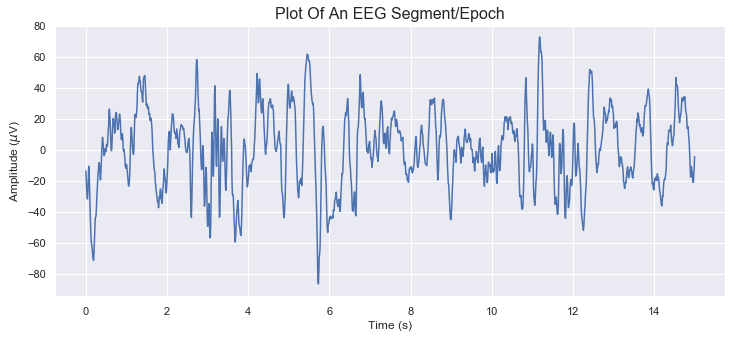

In [19]:
epoch_bool = (df_N2['epoch'] == 22)

# Time vector had a scaling factor of 1000 initially for each time unit. Need to divide vector by 1000 to revert back to ms.
t_temp = df_N2[epoch_bool]['time']
t = t_temp / 1e3 

# No need to re-scale. Values are in uV naturally.
y = df_N2[epoch_bool]['EEG Fpz-Cz']

# Plot the EEG epoch on a matplotlib figure
fig = plt.figure(figsize=(12,5))
plt.plot(t,y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Plot Of An EEG Segment/Epoch', fontsize=16)
plt.show()

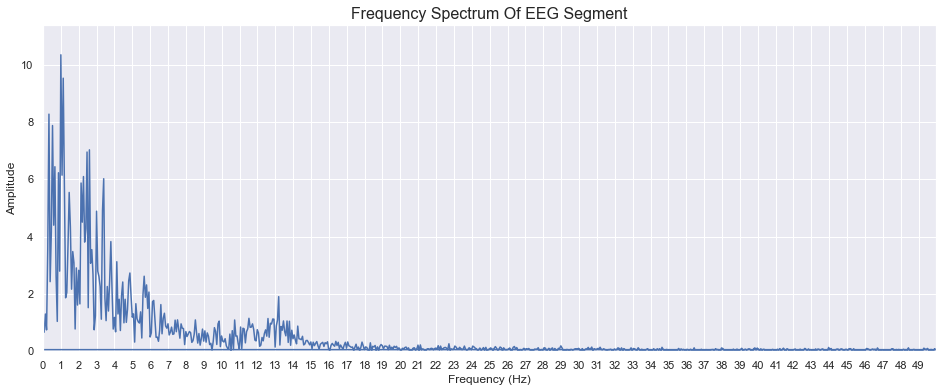

In [20]:
from scipy.fftpack import fft, fftfreq

# Call the transformed signal, F:
F = fft(y, len(y))
mag_spec = abs(F) / (len(y)/2)

# Obtain the frequency vector for the x-axis of the frequency spectrum
n = y.size
timestep = 0.01
F_x = np.fft.fftfreq(n, d = timestep)

# Plot the frequency spectrum of the signal:
fig = plt.figure(figsize=(16,6))
plt.plot(F_x, mag_spec)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum Of EEG Segment', fontsize=16)
plt.xlim([0, max(F_x)])
plt.ylim([0, max(mag_spec) + 0.1 * max(mag_spec)])
plt.xticks(np.arange( 0, max(F_x), 1.0 ))
plt.show()

We've picked epoch 46 as a candidate EEG segment that contains what <i>looks</i> to be a spindle with its onset <i>just</i> before 25 seconds and tapering before 30 seconds. The frequency spectrum shows what appears to be a large spike at 7 Hz which are due to the lower frequency components of the signal but not the spindle. In this case, it appears that the frequency spectrum does not accurately indicate whether we have a spindle in this particular segment. 

Alternative, we can use <b>wavelet convolution</b> to detect the presence of a spindles in a signal that fits the characteristics specified by the AASM definition of a spindle. To do this, we can:

1. Instantiate a wavelet such as a Morlet wavelet 
2. Perform a time-domain convolution between the raw EEG signal and the wavelet.
3. Compute the normalised-power of the convolved signal as a function of time. The normalised power should range from 0-1.
4. Extract the sections of the raw signal surpass the threshold power. These sections of the signal are likely to be spindles.

We perform the convolution in the subsequent code cell. I might write a dedicated script for this to make it easier to access and use in the latter parts of the project. The algorithm used was taken from Raphael Vallat's "A simple and efficient sleep spindle detector". The link to his guide is shown below.

https://raphaelvallat.com/spindles.html

<h3>Step 1: Instantiate A Morlet Wavelet</h3>

The standard Morlet wavelet is given by the following equation:

\begin{equation}
    \Psi(t) = \pi^{-0.25} \cdot e^{-t^2/2} \cdot e^{j\omega t}
\end{equation}

The equation for the generalised standard Morlet wavelet was obtained from the following paper in the link below.

https://www.researchgate.net/publication/226114632_The_Use_of_the_Mexican_Hat_and_the_Morlet_Wavelets_for_Detection_of_Ecological_Patterns

Where $\omega = 2\pi f$ is the angular frequency of the carrier component of the wavelet. Recall that the Morelet wavelet is essentially the point-wise time-domain multiplication of a Gaussian window and a sinusoidal wave. We can easily instantiate a morlet wavelet in using ```scipy.signal``` or using MNE as shown below.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


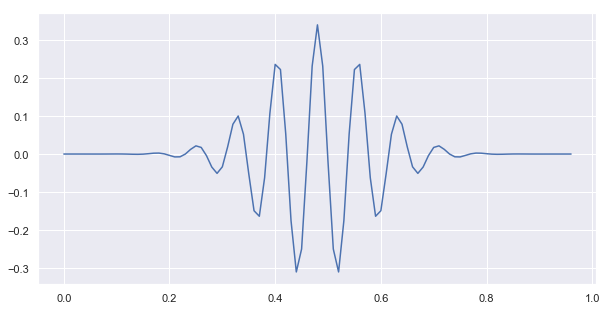

In [21]:
# Importing morlet function from MNE
from mne.time_frequency import morlet

# Specifying the value of input parameters to morlet:
sfreq = 100
spindle_freq = 13
n_cycles = 8

# Generating the morlet wavelet:
wlt = morlet(sfreq, [spindle_freq], n_cycles=n_cycles)[0]

# Obtain the time-vector for the signal:
t_vec_morlet = np.arange(len(wlt)) / sfreq
#t_vec_morlet = t_vec_morlet - (max(t_vec_morlet) / 2)

# Plot the Morlet wavelet.
fig = plt.figure(figsize=(10,5))
plt.plot(t_vec_morlet, wlt)
plt.show()

<h3>Step 2: Perform The Convolution</h3>

Let the wavelet be $\Psi(t)$ for $\Psi: \mathbb{C} \rightarrow \mathbb{C}$. The time-convolution between the signal and the wavelet (called a <b>Continuous-Wavelet Transform</b> or CWT) is given by the following integral:

\begin{equation}
    W(a,b) = \frac{1}{\sqrt{a}} \int_{-\infty}^{\infty} y(t) \cdot \psi^{*}\left(\frac{t - b}{a}\right) dt
\end{equation}

Where $a,b \in \mathbb{R}$ scale and translate the mother wavelet, $\psi(t)$ at $a = 1, b = 0$. In this case, the wavelet can be thought of as a windowing function that is flipped and time-shifted while undergoing point-wise multiplication that the wavelet is being convolved with. In this context, we choose parameters $a,b \in \mathbb{R}$ that fit the characteristics of a sleep spindle via the AASM definition. That is:

1. Frequency between 11-16 Hz (typically 12-14 Hz)
2. Duration between 0.5-2 seconds
3. Waxing and waning (Gaussian) envelope)

The definition of the CWT and its comparison with the usual Fourier transform and Gabor windowing is fully explained the paper shown in the link below.

<b>The Continuous Wavelet Transformation: A Tool For Signal Investigation And Understanding by <i>John Sadowsky</i></b>
https://www.jhuapl.edu/techdigest/views/pdfs/V15_N4_1994/V15_N4_1994_Sadowsky.pdf

In [22]:
# Convolve the original EEG signal with the wavelet:
analytic = np.convolve(y, wlt, mode='same')
amplitude = np.abs(analytic)
phase = np.angle(analytic)

# Get the power of the signal and normalise between 0 and 1
power = np.square(amplitude)
norm_power = (power - power.min()) / (power.max() - power.min())

# Set threshold power to be 0.20
thresh = 0.20

# Create boolean condition for when power is above the threshold:
beyond_thresh = np.where(norm_power >= thresh)[0]

In [23]:
# First, we should convert the raw eeg signal and the associated time vector to normal arrays:
t_np = t.values
y_np = y.values

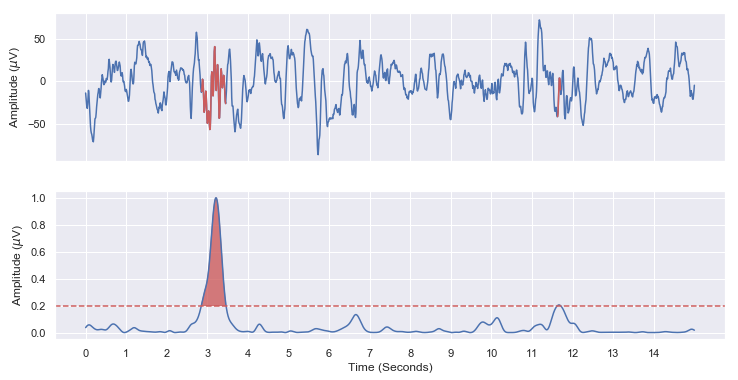

In [24]:
# Create a vector NaNs of the same length as the raw EEG signal
spindles = np.nan * np.zeros(len(y_np))

# Assign, to the NaN vector the sections of the EEG that meet the power criteria. Assign those sections to the 
# NaN vector. This should give rise to a vector where particular indices are sections of the EEG signal that correspond to spindles.
spindles[beyond_thresh] = y_np[beyond_thresh]

# Plot both the raw EEG signals and the sections that correspond to spindles.
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6), sharex=True)

ax1.plot(t, y_np)
ax1.plot(t, spindles, color='indianred')
ax1.set_xticks(np.arange(0, max(t), 1))

ax2.plot(t, norm_power)
ax2.axhline(y = 0.2, linestyle='--', color='indianred')

plt.xlabel('Time (Seconds)')
ax1.set_ylabel('Amplitude ($\mu$V)')
ax2.set_ylabel('Amplitude ($\mu$V)')

ax2.fill_between(t, norm_power, thresh, where = norm_power >= thresh,
                 color='indianred', alpha=.8)

plt.show()

For epoch 4, we have a section of the EEG that appears to have a waxing and waning structure between 3-5 seconds. Let's see if we can extract this section of the EEG and observe this potential spindle in closer detail. We do this in the following code cell. 

In [25]:
from scipy.signal import detrend

# Extract the start and end of each spindle:
sp = np.split(beyond_thresh, np.where(np.diff(beyond_thresh) != 1)[0] + 1)
idx_start_end = np.array([[k[0], k[-1]] for k in sp])

# Extract the duration (in ms) of each spindles
sp_dur = (np.diff(idx_start_end, axis=1) / sfreq).flatten()

# Extract the peak-to-peak amplitude and frequency
sp_amp, sp_freq = np.zeros(len(sp)), np.zeros(len(sp))

for i in range(len(sp)):
    # Important: detrend the signal to avoid wrong peak-to-peak amplitude
    sp_amp[i] = np.ptp(detrend(y_np[sp[i]]))

    # Median of the instantaneous frequency of the spindles, where:
    # inst_freq = sf / 2pi * 1st-derivative of the phase of the analytic signal
    sp_freq[i] = np.median((sfreq / (2 * np.pi) * np.diff(phase[sp[i]])))

In [26]:
sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq,
             'Amplitude (uV)': sp_amp}

print(sp_params)

print()

print(idx_start_end / sfreq)

{'Duration (ms)': array([0.59, 0.07]), 'Frequency (Hz)': array([13.11031443, 11.97634561]), 'Amplitude (uV)': array([92.89013623, 31.81915228])}

[[ 2.86  3.45]
 [11.63 11.7 ]]


That is, the first spindle that occurs, which really is the only spindle in this particular case occurs at indices 366 to 476. We can use these indices to extract the appropriate portion of the time vector and the raw EEG vector. We perform this in the following code cell.

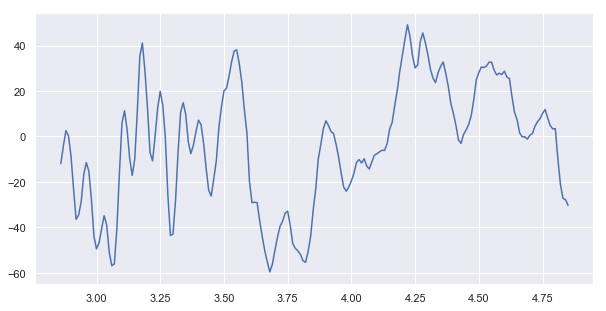

In [27]:
sp_start = idx_start_end[0][0]
sp_end = idx_start_end[0][1]

spindle_raw = y_np[sp_start: sp_end + 141]
t_spindle = t_np[sp_start:sp_end + 141]

fig = plt.figure(figsize=(10,5))
plt.plot(t_spindle, spindle_raw)
plt.show()

However, this segment is still contains components from all slower components of the raw EEG signal. We need to perform a bandpass filter on this segment with a centre frequency of 13Hz. The lower and upper cutoff frequencies of the bandpass filter will be set as 12 and 14 Hz respectively, consistent with the <i>typical</i> range for a spindle as defined by the AASM. We perform the filtering below.

In [28]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

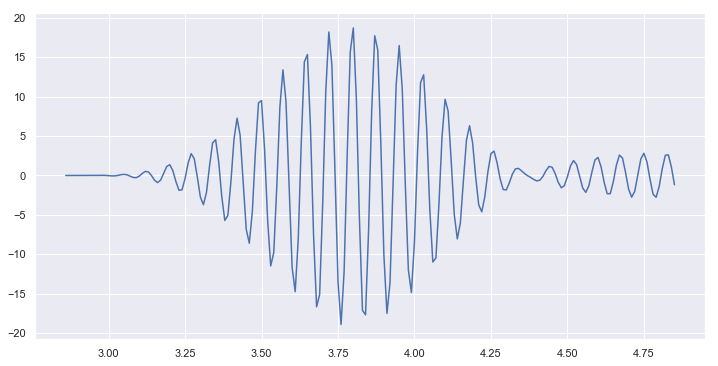

In [29]:
low = 12
high = 14

spindle_filtered = butter_bandpass_filter(spindle_raw, low, high, sfreq, order=5)

fig = plt.figure(figsize=(12,6))
plt.plot(t_spindle, spindle_filtered)
plt.show()

In [30]:
len(spindle_filtered)

200

<h3>How did the CWT Work</h3>

The CWT can be thought of as a bandpass filter applied to a signal. To better understang this, we plot the frequency spectrum of the raw signal once more and superimpose a plot of the frequency spectrum of the Morlet wavelet. This is performed in the subsequent code cell.

In [31]:
# Perform a fourier transform on the Morlet wavelet
fft_wlt = fft(wlt, n = mag_spec.size)
mag_wlt = abs(fft_wlt)

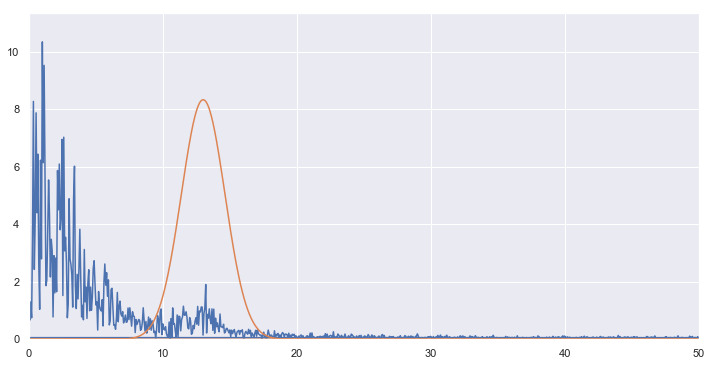

In [32]:
fig = plt.figure(figsize=(12,6))

plt.plot(F_x, mag_spec)
plt.plot(F_x, mag_wlt)
plt.xlim([0, max(F_x)])
plt.ylim([0, max(mag_spec) + 1])
plt.show()

In this case, the wavelet produces a Gaussian window centred at 13 Hz. Because time-convolution is multiplication in the frequency domain, the Gaussian window only obtains frequencies within its bandwidth. This allows spindles to be easily detected within the desired 12-14 Hz range easily whilst disregarding all slower EEG components.

<h3>Adapting the QPS model to the filtered spindle</h3>

Now that we have detected the spindle using the Morlet wavelet, we are ready to fit the QPS model to the filtered EEG spindle. Recall that the QPS wavelet is an analytic signal that is essentially a Gaussian modulated sine wave in the following form:

\begin{equation}
    s(t) = exp(a + bt + ct^2) \cdot cos(d + et + ft^2) \equiv \mathcal{R}\{exp\left(A(t)\right)\cdot exp(j\theta(t))\}
\end{equation}

Where:

- $a$: Amplitude
- $b$: Time-shifting
- $c$: Envelope decay
- $d$: Phase offset of carrier component
- $e$: Angular frequency of carrier component (rad/s)
- $f$: Intra-spindle frequency variation

The quadratic arguments for the exponential and the carrier component are due to the fact that the instantaneous frequency of this wavelet needs to be time-varying or <i>non-stationary</i>. For this to occur, the instantaneous frequency, $F(t)$ needs to be at least a linear polynomial. But we know that the instaneous frequency of the signal is related to the instantaneous phase, $\theta(t)$ via the following equation:

\begin{equation}
    F(t) = \frac{1}{2\pi} \cdot \frac{d\theta(t)}{dt}
\end{equation}

For this condition to be satisified, the instantaneous phase needs to be a quadratic polynomial at minimum. As a result, we can make the argument of the carrier component a quadratic polynomial with coefficients. Likewise, we can assign a quadratic polynomial to the amplitude function as a power of the exponential factor.

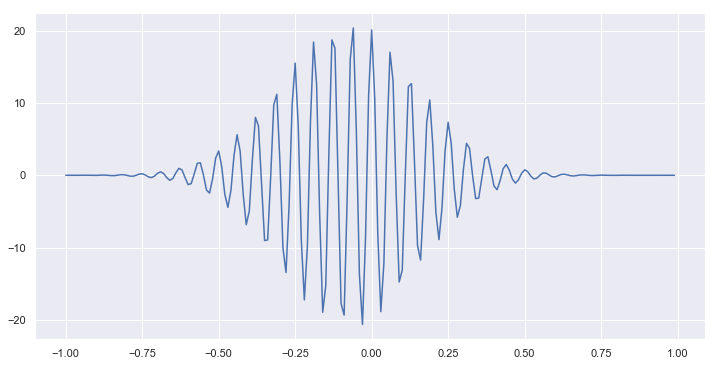

In [33]:
from wavelet_generator import qps_time_sig

t = np.arange(-1, 1, 1/sfreq)

a,b,c,d,e,f = 3, -1.5, -10, 0, 100, 0

s = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)

fig = plt.figure(figsize=(12,6))
plt.plot(t,s)
plt.show()

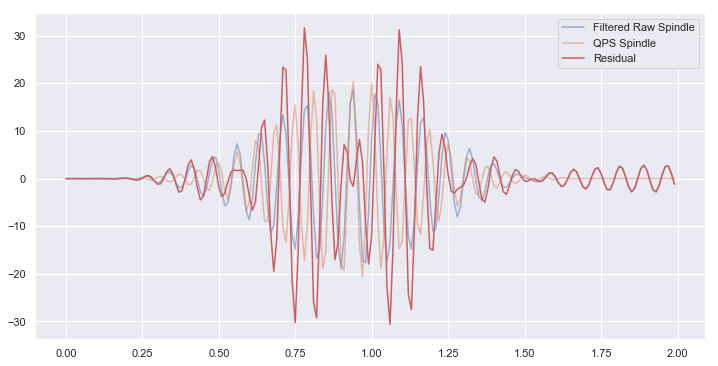

In [34]:
fig = plt.figure(figsize=(12,6))

plt.plot(t_spindle - min(t_spindle), spindle_filtered, alpha=0.5, label='Filtered Raw Spindle')
plt.plot(t_spindle - min(t_spindle), s, alpha=0.5, label="QPS Spindle")
plt.plot(t_spindle - min(t_spindle), spindle_filtered - s, color='indianred', label="Residual")

plt.legend()

plt.show()

In [35]:
from lmfit import Parameters, minimize

def residual(params, t, data):
    a, b, c = params['a'], params['b'], params['c']
    d, e, f = params['d'], params['e'], params['f']

    model = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)
    chi = (data - model)
    
    return chi

# Set up an empty set of parameters:
params = Parameters()
params.add('a', value=3)
params.add('b', value=0)
params.add('c', value=-15)
params.add('d', value=0)
params.add('e', value=100)
params.add('f', value=0)
    
out = minimize(residual, params, args=(t, spindle_filtered))

In [36]:
out

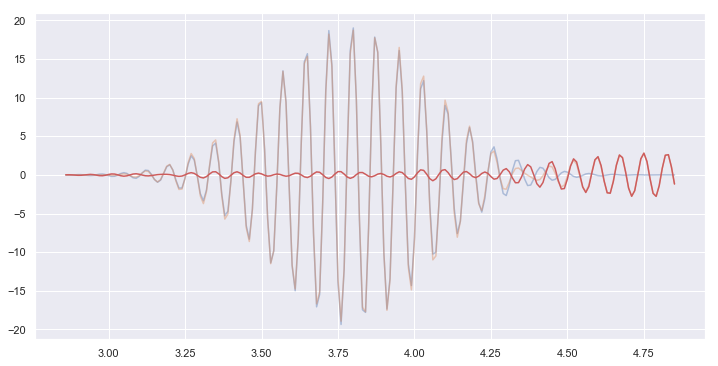

In [37]:
a,b,c,d,e,f = 2.93560420, -1.05285677, -7.60653031, -1.11159826, 82.3362346, -1.87785302

s_fit = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)

fig = plt.figure(figsize=(12,6))
plt.plot(t_spindle, s_fit, alpha=0.4)
plt.plot(t_spindle, spindle_filtered, alpha=0.4)
plt.plot(t_spindle, spindle_filtered - s_fit, color='indianred')

plt.show()

We can see that the residual has minimised significantly suggesting the best fit of the QPS spindle has been achieved. The oscillation after 4.25 seconds in the above plot can be disregrarded as it occurs after the end of the spindle oscillation. 

For the above spindle, the value of the parameter $e$ was determined to be <b>82.3362346</b> after the NLLS optimisation. The value of $e$ turns out to be the angular frequency of the spindle (in rad/s). Converting this value to a normal frequency (in Hz), we find the value is, in fact <b>13.104 Hz</b> (to 5 significant figures). This fits comfortably within the median of the <i>typical range</i> of a sleep spindle defined by the AASM (that is, a spindle has a frequency anywhere between 12-14 Hz).

<h2>Next Steps</h2>

While the Morlet wavelet can detect the spindles to a good degree of accuracy without the need to perform manual guessing of the parameter values and NLLS can be used to obtain the parameter values, unless we have confirmation from visual scoring (via sleep clinicians), we cannot be 100% certain that the spindles detected via CWT are certain.

In a separate notebook, the DREAMS database will be used to perform the same analysis. The DREAMS database contains PSG recordings of 8 patients where spindles have been recorded and scored including the times that the spindles occur in the recording. That way, we have a reference to compare the automatic detection to in the case we detect a false positive (FP) rather than a true positive (TP). Further extraction will be performed in a separate note book with dedicated scripts.